In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import os, cv2, re, random, time, zipfile, gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import layers, models, optimizers
#from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam
import efficientnet.tfkeras as efn


In [2]:
TRAIN_DIR = ['/home/students/acct2013_01/CHY/datasets/train/dog/', '/home/students/acct2013_01/CHY/datasets/train/cat/']
VAL_DIR = ['/home/students/acct2013_01/CHY/datasets/val/dog/', '/home/students/acct2013_01/CHY/datasets/val/cat/']
TEST_DIR = '/home/students/acct2013_01/CHY/datasets/test/'

train_images = []
test_images = []
val_images = []
# train_images
for path in TRAIN_DIR:
    for i in os.listdir(path):
        train_images.append(os.path.join(path, i))

# val_images
for path in VAL_DIR:
    for i in os.listdir(path):
        val_images.append(os.path.join(path, i))  

test_images = [TEST_DIR+i for i in sorted(os.listdir(TEST_DIR))]

The shape of train data is (20000, 128, 128, 3)
The shape of validation data is (5000, 128, 128, 3)
The shape of test data is (500, 128, 128, 3)


<AxesSubplot:ylabel='count'>

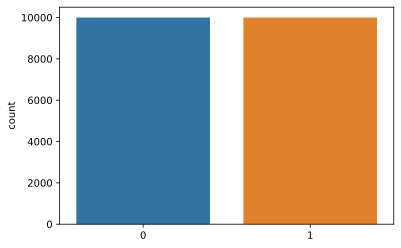

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
train_x = []
for img in train_images:
    train_x.append(cv2.resize(cv2.imread(img), 
                        (IMG_WIDTH, IMG_HEIGHT), 
                        interpolation=cv2.INTER_CUBIC))

val_x = []
for img in val_images:
    val_x.append(cv2.resize(cv2.imread(img), 
                        (IMG_WIDTH, IMG_HEIGHT), 
                        interpolation=cv2.INTER_CUBIC))
    
test = []
for img in test_images:
    test.append(cv2.resize(cv2.imread(img), 
                        (IMG_WIDTH, IMG_HEIGHT), 
                        interpolation=cv2.INTER_CUBIC))
    
print('The shape of train data is {}'.format(np.array(train_x).shape))
print('The shape of validation data is {}'.format(np.array(val_x).shape))
print('The shape of test data is {}'.format(np.array(test).shape))

# extract label vector
plt.rcParams['figure.facecolor'] = 'white'
train_y = []
for i in train_images:
    if 'dog' in i:
        train_y.append(1)
    elif 'cat' in i:
        train_y.append(0)

val_y = []
for i in val_images:
    if 'dog' in i:
        val_y.append(1)
    elif 'cat' in i:
        val_y.append(0)

train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)
test = np.array(test)
sns.countplot(train_y)

In [4]:
import tensorflow as tf
model = models.Sequential()


efnModel = efn.EfficientNetB7(weights = 'imagenet', 
                       input_shape = (IMG_WIDTH, IMG_HEIGHT,3), 
                       include_top = False)
model.add(efnModel)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1, activation='sigmoid'))

# decay is included for backward compatibility to allow time inverse decay of lr
opt = Adam(lr=1e-2) 

model.compile(loss='binary_crossentropy',
              optimizer = opt, 
              metrics = ['accuracy'])

model.summary()

2021-11-07 21:03:04.559245: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/students/acct2013_01/hy_ee4483/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-07 21:03:04.559723: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-07 21:03:04.560043: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 4, 4, 2560)       64097680  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2561      
                                                                 
Total params: 64,100,241
Trainable params: 63,789,521
Non-trainable params: 310,720
_________________________________________________________________


Found 1 validated image filenames belonging to 1 classes.


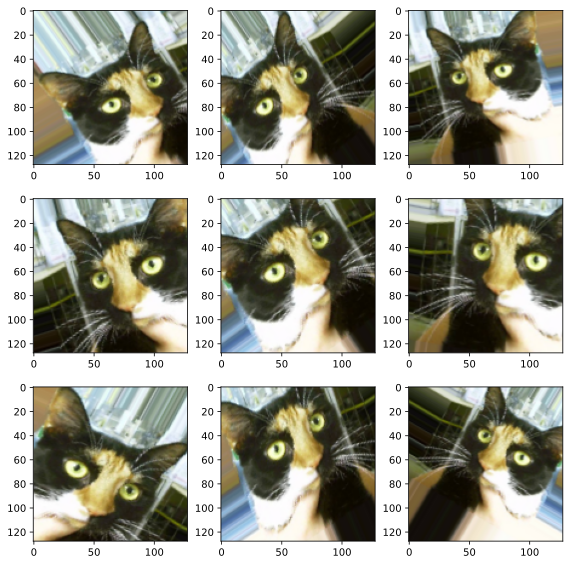

In [13]:
def plot_gened(train_images,seed=320):
    '''plot pictures after processing
    '''
    df = pd.DataFrame({'filename': train_images})
    np.random.seed(seed)
    vis_df = df.sample(n=1).reset_index(drop=True)
    vis_df['category'] = '0'
#vis_df
    vis_gen = ImageDataGenerator(
            rescale=1. / 255,             # Scale data to 0-1 range
            rotation_range=40,            # The angle range of the image randomly rotated
            width_shift_range=0.2,        # The range of image translation in the horizontal direction
            height_shift_range=0.2,       # The range of image translation in the vertical direction
            shear_range=0.2,              # Random staggered transformation angle
            zoom_range=0.2,               # Random image zoom range
            horizontal_flip=True,         # Randomly flip half of the image horizontally
            fill_mode='nearest')          # How to fill in newly created pixels

    vis_gen0 = vis_gen.flow_from_dataframe(vis_df,
                                       x_col='filename',
                                       y_col='category',
                                       target_size=(IMG_WIDTH, IMG_HEIGHT),
                                       batch_size = 16)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.figure(figsize=(8, 8))
    for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in vis_gen0:
            image = X_batch[0]
            plt.imshow(image)
            break
    plt.tight_layout()
    plt.show()
    
plot_gened(train_images)

In [5]:
# 
#
# efficientNetb7
datagen = ImageDataGenerator(
            rescale=1. / 255,             # Scale data to 0-1 range
            rotation_range=40,            # The angle range of the image randomly rotated
            width_shift_range=0.2,        # The range of image translation in the horizontal direction
            height_shift_range=0.2,       # The range of image translation in the vertical direction
            shear_range=0.2,              # Random staggered transformation angle
            zoom_range=0.2,               # Random image zoom range
            horizontal_flip=True,         # Randomly flip half of the image horizontally
            fill_mode='nearest')          # How to fill in newly created pixels

val_datagen = ImageDataGenerator(rescale=1./255)
val_x = np.array(val_x)
val_y = np.array(val_y)
import tensorflow as tf
with tf.device('/device:GPU:1'):
    BATCH_SIZE = 32
    datagen = datagen.flow(train_x, train_y, batch_size=BATCH_SIZE)
    val_datagen = val_datagen.flow(val_x, val_y, batch_size=BATCH_SIZE)

    earlystop1 = EarlyStopping(patience=5)
    earlystop2 = ReduceLROnPlateau(monitor = 'val_accuracy', min_lr = 0.00001, 
                                patience = 5, mode = 'min', factor = 0.2, 
                                verbose = 1)

    history = model.fit(datagen, 
                        steps_per_epoch=45,
                        epochs=40,
                        validation_data=val_datagen,
                        callbacks=[earlystop1, earlystop2],
                        validation_steps=25)

    model.save('dogs_cats_efficientnetb7.h5')

Epoch 1/40
45/45 [==============================] - 124s 2s/step - loss: 1.2688 - accuracy: 0.4882 - val_loss: 77774299594752.0000 - val_accuracy: 0.5163 - lr: 0.0100
Epoch 2/40
45/45 [==============================] - 102s 2s/step - loss: 0.7326 - accuracy: 0.5132 - val_loss: 1067363.6250 - val_accuracy: 0.4888 - lr: 0.0100
Epoch 3/40
45/45 [==============================] - 102s 2s/step - loss: 0.7157 - accuracy: 0.5465 - val_loss: 442.1711 - val_accuracy: 0.4712 - lr: 0.0100
Epoch 4/40
45/45 [==============================] - 102s 2s/step - loss: 0.6909 - accuracy: 0.5771 - val_loss: 1740.5760 - val_accuracy: 0.5125 - lr: 0.0100
Epoch 5/40
45/45 [==============================] - 102s 2s/step - loss: 0.7062 - accuracy: 0.5375 - val_loss: 1.5956 - val_accuracy: 0.5888 - lr: 0.0100
Epoch 6/40
45/45 [==============================] - 101s 2s/step - loss: 0.6937 - accuracy: 0.5688 - val_loss: 1.0121 - val_accuracy: 0.5075 - lr: 0.0100
Epoch 7/40
45/45 [==============================] - 

In [1]:
plt.rcParams['figure.facecolor'] = 'white'
model_loss = pd.DataFrame(history.history)
model_loss.head()
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);
model_loss[['loss','val_loss']].plot(ylim=[0,1]);

NameError: name 'plt' is not defined

In [34]:
test = []
for img in test_images:
    test.append(cv2.resize(cv2.imread(img), 
                        (IMG_WIDTH, IMG_HEIGHT), 
                        interpolation=cv2.INTER_CUBIC))
test = np.array(test)
test


array([[[[ 22,  24,  32],
         [ 29,  31,  39],
         [ 18,  20,  28],
         ...,
         [119, 110, 107],
         [118, 109, 106],
         [114, 105, 102]],

        [[ 54,  56,  64],
         [ 47,  49,  57],
         [ 28,  30,  38],
         ...,
         [119, 110, 107],
         [118, 109, 106],
         [117, 108, 105]],

        [[ 43,  45,  53],
         [ 49,  51,  59],
         [ 37,  39,  47],
         ...,
         [117, 110, 107],
         [116, 109, 106],
         [114, 107, 104]],

        ...,

        [[ 67,  78,  86],
         [ 60,  77,  91],
         [ 61,  82,  99],
         ...,
         [112, 110, 110],
         [117, 114, 115],
         [145, 142, 144]],

        [[ 70,  82,  87],
         [ 75,  87, 101],
         [ 79,  91, 110],
         ...,
         [111, 107, 108],
         [116, 114, 114],
         [144, 143, 146]],

        [[ 69,  81,  86],
         [ 82,  95, 108],
         [ 80,  92, 112],
         ...,
         [103, 105, 110],
        

In [35]:
test = test.astype('float32') / 255
test_pred = np.where(model.predict(test)>0.5,1,0)
submission = pd.DataFrame({'id': range(1, len(test_images) + 1), 'label': test_pred.ravel()})
submission.to_csv('submission_b7.csv', index = False)
submission

,id,label
0,1,0
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
495,496,0
496,497,1
497,498,0
498,499,0


In [6]:
datagen = ImageDataGenerator(
            rescale=1. / 255,             # Scale data to 0-1 range
            )          # How to fill in newly created pixels

val_datagen = ImageDataGenerator(rescale=1./255)
val_x = np.array(val_x)
val_y = np.array(val_y)
import tensorflow as tf
with tf.device('/device:GPU:1'):
    BATCH_SIZE = 16
    datagen = datagen.flow(train_x, train_y, batch_size=BATCH_SIZE)
    val_datagen = val_datagen.flow(val_x, val_y, batch_size=BATCH_SIZE)

    earlystop1 = EarlyStopping(patience=5)
    earlystop2 = ReduceLROnPlateau(monitor = 'val_accuracy', min_lr = 0.00001, 
                                patience = 5, mode = 'min', 
                                verbose = 1)

    history = model.fit(datagen, 
                        steps_per_epoch=45,
                        epochs=20,
                        validation_data=val_datagen,
                        callbacks=[earlystop1, earlystop2],
                        validation_steps=25)

    model.save('dogs_cats_efficientnetb0_without_augmentation.h5')

Epoch 1/20
45/45 [==============================] - 19s 313ms/step - loss: 0.4980 - accuracy: 0.7764 - val_loss: 0.2725 - val_accuracy: 0.9075 - lr: 1.0000e-04
Epoch 2/20
45/45 [==============================] - 13s 287ms/step - loss: 0.2972 - accuracy: 0.8958 - val_loss: 0.1920 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 3/20
45/45 [==============================] - 13s 289ms/step - loss: 0.2267 - accuracy: 0.9139 - val_loss: 0.1706 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 4/20
45/45 [==============================] - 13s 283ms/step - loss: 0.2274 - accuracy: 0.9083 - val_loss: 0.1394 - val_accuracy: 0.9450 - lr: 1.0000e-04
Epoch 5/20
45/45 [==============================] - 13s 283ms/step - loss: 0.1947 - accuracy: 0.9236 - val_loss: 0.1436 - val_accuracy: 0.9450 - lr: 1.0000e-04
Epoch 6/20
45/45 [==============================] - 13s 282ms/step - loss: 0.1592 - accuracy: 0.9444 - val_loss: 0.1502 - val_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 7/20
45/45 [======================

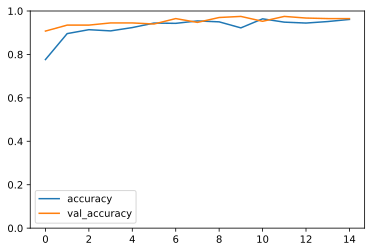

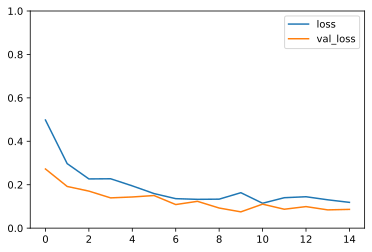

In [7]:
plt.rcParams['figure.facecolor'] = 'white'
model_loss = pd.DataFrame(history.history)
model_loss.head()
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);
model_loss[['loss','val_loss']].plot(ylim=[0,1]);